<a href="https://colab.research.google.com/github/jdhammond/supreme-lamp/blob/main/NYCDOE_Summer_Hiring_Gather_and_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In the spring of 2021, teachers at my school were tired. Other teacher friends at other schools were tired. The media [made](https://www.wsj.com/articles/teachers-are-quitting-and-companies-are-hot-to-hire-them-11643634181) [noises](https://www.npr.org/2022/02/01/1076943883/teachers-quitting-burnout) about teachers quitting. 

Impressions and water-cooler talk are one thing, but I wondered: To what extent is this true in New York City? What qualititative data could be gathered on the subject? Is there a way that I could gather quantitative data on vacant jobs and hiring during the summer after a taxing post-lockdown school year? 

#The Goal

In this project, I aggregate data on hiring of teachers at schools in the New York City Department of Education (hereafter, DOE). 

This notebook covers the gathering, cleaning, and transformation of the data. Later, I will conduct analysis to
- visualize and detect trends in job vacancies and DOE hiring, and perhaps
- find actionable ways that hiring principals and/or job seekers could improve their outcomes

In this process, I use
- pandas
- Selenium
- SQL (BigQuery)
- requests
- urllib

#Open Market

The DOE maintains a portal called Open Market (OM) on which schools can post job listings, and through which current teachers can search and apply. 

Open Market is for current DOE teachers only. While it is open, teachers can move between schools, if they are hired at a different DOE school. When OM closes a month before school starts (in 2022, that's August 8), current teachers are locked into their then-current schools. Outstanding vacancies must be filled by new hires. 

#Gathering data

To start this process, here's a script to facilitate the scraping of jobs data from OM.


In [ ]:
from selenium import webdriver

# Initialize Firefox webdriver. 
browser = webdriver.Firefox()

# Navigate to login page for open market. 
browser.get('https://www.nycenet.edu/offices/dhr/transferplane/apps/login.aspx')

# Target fields for user id, password, and login button.
user_id = browser.find_element_by_id('_PageTemplate_innerHolder_txtUserID')
pw = browser.find_element_by_id('_PageTemplate_innerHolder_txtPwd')
sign_in_button = browser.find_element_by_id('_PageTemplate_innerHolder_btnLogin')

# My username and password are omitted here.
my_user_id = *****
my_pw = *****

# Log in
user_id.click()
user_id.send_keys(my_user_id)
pw.click()
pw.send_keys(my_pw)
sign_in_button.click()

In OM, searching listings without specifying any criteria (subject, location, etc.) returns ALL available listings that day. So, the script does that, and then clicks a button that exports search results as a .xls file.

In [ ]:
# Navigate to search page, now that we're logged in.
browser.get('https://www.nycenet.edu/offices/dhr/transferplane/apps/SearchSchoolVacancies.aspx')

# Click Search button with no further input to retrieve all results. Download into excel.
browser.find_element_by_id('_PageTemplate_innerHolder_btnSearch').click()
browser.find_element_by_id('_PageTemplate_innerHolder_btnExportTop').click()

# The file name is "Report", or if Report.xls already exists, "Report(1)", and Report(2) if that already exists, etc. 

Data caveats:

- Open Market opened on April 13, 2022. I started collecting data on May 29. I will continue until August 8, 2022, which is when OM closes.
- After 5/29, there are two gaps in the data:
    - 6/1 to 6/2, inclusive, due to human error
    - 7/8 - 7/10, inclusive, when OM was down




Let's inspect the data. Opening the report file, we see: 

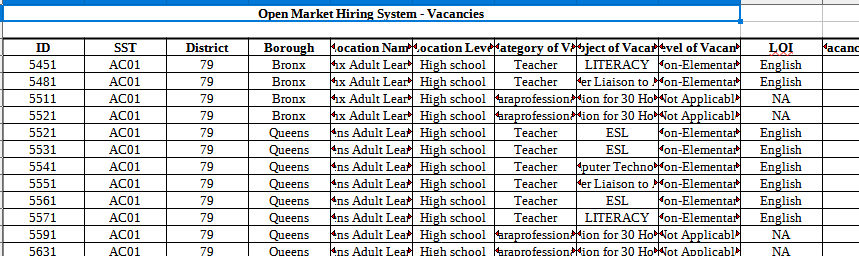

- After two decorative rows at the top, there is a header row.
- Below that, each job listing has a row of data.
- Various other information, buttons, and formatting are rendered into the excel file near the bottom, including a cell with the datetime at which the search was conducted. This will be useful later.

image-2.png
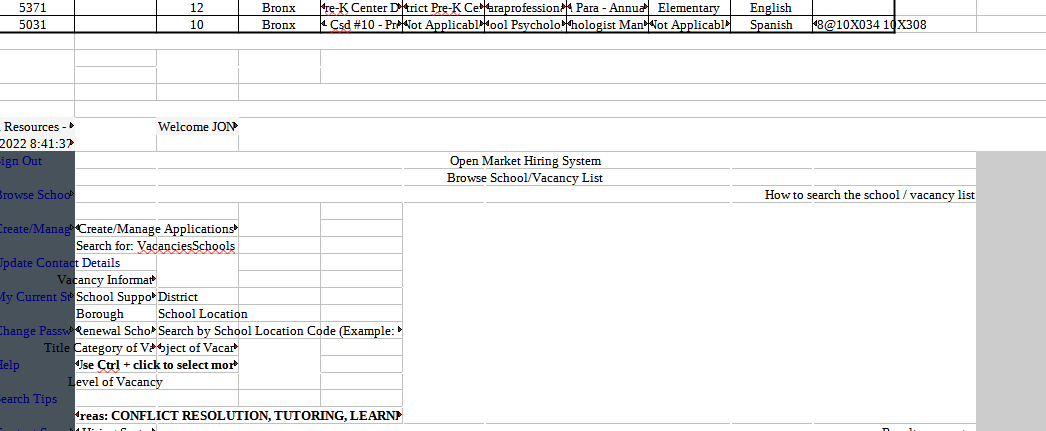

We will concatenate all the daily reports we have downloaded into a single dataframe. When I tried...:


In [ ]:
import pandas as pd

filepath = "/content/Report.xls"
df = pd.read_excel(filepath, engine="xlrd") # engine for .xls files as opposed to newer Excel format
print(df.head(5))

...I got a persistent XLRD error; read_excel gets stuck on the HTML elements of the spreadsheet. A workaround is to save the report as an .ods file, and then use

In [ ]:
import pandas as pd
filepath = "/content/Report.ods"
df = pd.read_excel(filepath, engine='odf', header=None, index_col=None) # The column names are in row 3, so don't count on read_excel to find them automatically
print(df.head(5))

With the data loaded, we need to remove rows that don't contain job listing information. 

We will also add, to each row, the date on which the report was generated, so that we can later find the start and end dates of each listing. 

And, we need to do this to many daily reports before appending them. So,  here is a function that accepts as an argument the filename of an OM-generate spreadsheet, opens that sheet, and cleans it: 

In [ ]:
def omt_trim(filename):
    
    # Open the file
    filepath = "...\\OMT_data_2022\\" + filename + ".ods"
    df = pd.read_excel(filepath, engine='odf', header=None, index_col=None)
    
    # Drop rows above relevant data    
    df.drop([0, 1, 2], inplace=True) 
    

The number of listings will vary day to day, but a cell containing the string "Division of Human Resources - Corporate Systems" always appears 6 rows below the job listing data and 1 row above the datetime of the report's creation. Use that information to extract the datetime and drop the irrelevant rows at the end.


In [ ]:
# Find the telltale string. Get its index as an integer.     
end_of_data = df.loc[df[0] == "Division of Human Resources - Corporate Systems"] 
eod_index = end_of_data.index.values[0] 

# Get datetime
old_datetime = df.iat[eod_index-2, 0] # This is not the expected number to have to subtract from eod_index, but it is what works. Something about odf's parsing of the file, I think.
datetime = datetime_convert(old_datetime) # We'll need a function to convert the datetime to a format compatible with BigQuery -- see below

# Drop rows at bottom
print("Dropping excess rows...")
df.drop(df.index[eod_index-8:eod_index+50], inplace=True)

Name the columns of the trimmed dataframe. Add a column for datetime, and fill it with the datetime that the file was downloaded. This represents that this listing existed at this time on this day. 

In [ ]:
df.columns = ['id','sst','district','borough','location_name','location_level','title','vacancy_subject','vacancy_level','loi','details','datetime']
df['datetime'] = datetime

Some quirks of the "ID" column as generated by Open Market:
- The 4 digit ID is _not_ unique. Different listings can share the same ID.
- However, the same ID never occurs at the same school, so by combining the ID and the school's location code -- the 4-character string at the beginning of the location_name -- we can generate a new ID that will be truly unique for each listing, and that will remain consistent for each listing until it's filled.


In [ ]:
unique_ids = []
for row in range(len(df.index)):
    old_id = df['id'].iloc[row]
    loc_code = (str(df['location_name'].iloc[row]))[:4]
    # Reassign loc codes starting with E to start with F instead. Otherwise, to_csv persistently converts strings to numbers in scientific notation. 
    if loc_code[0] == 'E':
        loc_code = 'F' + loc_code[1:]
    new_id = str(old_id) + str(loc_code) 
    unique_ids.append(str(new_id))

df['unique_id'] = unique_ids

# Return the trimmed dataframe
return df

The only time a unique_id like this is reused is if the posting is edited (for example, if a general science job is revised to be a chemistry job specifically). It's worth preserving these changes because they'll help show changing staffing needs as the summer goes on. 

We need two more functions for this to work: a function to convert datetimes from the format provided by OM, to one that BigQuery will recognize later: 

In [ ]:
# Convert datetime to YYYY-MM-DD hh:mm:ss for BigQuery compatibility
def datetime_convert(dt):
    dt_parts = dt.split()
    print(dt_parts)
    date = dt_parts[0]
    time = dt_parts[1]
    ampm = dt_parts[2]
    mdy = date.split('/')
    month = mdy[0]
    if len(month) == 1:
        month = "0" + month
    day = mdy[1]
    if len(day) == 1:
        day = "0" + day
    year = mdy[2]
    ymd = "-".join([year, month, day])

    hms = time.split(':')
    hour = hms[0]
    min = hms[1]
    sec = hms[2]
    if ampm == "PM" and int(hour) < 12:
        hour = str(int(hour) + 12)
    if ampm == "AM" and hour == "12":
        hour = "00"
    if len(hour) == 1:
        hour = "0" + hour
    hms = ":".join([hour, min, sec])
    datetime = ymd + " " + hms
    print(datetime)
    return datetime

Second, we need an efficient way to pass to omt_trim all of the daily downloaded files that we wish to concatenate:

In [ ]:
# Make a list of filenames; n = number of files besides initial "Report" file
def make_file_list(n):
    all_filenames = ["Report"]
    for i in range(n):
        all_filenames.append("Report(" + str(i+1) + ")")
    print(all_filenames)
    return all_filenames

Finally, we can call these functions to combine any number of daily reports from OM into a single file, in which
- each listing has a row for each day that it was present
- each row has a datetime at which the listing was present on OM
- each listing has a unique ID that is consistent for the whole time that it is posted on OM


In [ ]:
# Trim and combine a list of odf filenames
all_filenames = make_file_list(50)
trim_1 = omt_trim(all_filenames[0])
trim_2 = omt_trim(all_filenames[1])
combined = pd.concat([trim_1, trim_2])
for i in range(len(all_filenames)-2):
    trim_i = omt_trim(all_filenames[i+2])
    combined = pd.concat([combined, trim_i])
    # print df info each time for monitoring purposes. Watch it grow!
    combined.info()

print(combined.head(5))
print(combined.tail(5))

# Export to CSV - CHANGE FILENAME to reflect date
combined.to_csv(r"C:\Users\17742\Documents\OMT_data_2022\full_OMT_report_25Jul22.csv", index=False)

An alternative was to create a script that would add one new report to a large file that contained all the previous reports, aggregated. However, trying to read that large file (30+ MB) into a dataframe caused memory errors. 

Also because of the size of the aggregated data file, SQL is the best tool for the next step. Upload to BigQuery and run the following.

In [ ]:
SELECT
 unique_id,
 district,
 borough,
 location_name,
 location_level,
 title,
 vacancy_subject,
 vacancy_level,
 DATE(MIN(datetime)) AS start_date,
 DATE(MAX(datetime)) AS end_date,
FROM `open-market-2022.omt_listings.full_OMT_report_25Jul22`
GROUP BY unique_id, 
 district,
 borough,
 location_name,
 location_level,
 title,
 vacancy_subject,
 vacancy_level

The result is a table in which each job listing has a row with salient information about the posting, INCLUDING when it first appeared on Open Market and the last day that it appeared (either because it was taken down, or because it was still up as of that day's scraping of OM).

Download the table as a CSV. 

In order to analyze geographic dimensions of the data, I want to find the geocode of each job listing. 

In [ ]:
import pandas as pd
from selenium import webdriver
import requests
import urllib.parse

def main():
        
    # Open report from BigQuery.
    filepath = r"C:\Users\17742\Documents\OMT_data_2022\omt_start_end_dates_25Jul22.csv"
    df_in = pd.read_csv(filepath)
    print("General data loaded")

    # In some cases, one ID will have two rows, where the listing was edited by the school. This is fine to include, because it better reflects hiring changes.
    # However, it means that I have to be careful with count(unique)s in Tableau or other analysis.

    print(df_in.head(5))

    # Open CSV with all the geodata we have so far, to reduce online lookups
    filepath = r"C:\Users\17742\Documents\OMT_data_2022\output_with_dates_and_geo_thru_14Jul22.csv"
    geodata = pd.read_csv(filepath, usecols = ['location_code','latitude','longitude'])
    print("Geodata loaded")

The "CSV with all the geodata we have so far" was originally from a 2016 Kaggle dataset of NYC schools. However, some schools may not have existed then, or may otherwise have been excluded from that set, so we need a way to fill in the gaps. 

In each subsequent use of this script, I redirect it to the geodata in results of the previous use, to avoid repetitive searching. 

In [ ]:
   # Create columns for latitude and longitude
    df_in["latitude"] = None
    df_in["longitude"] = None

    # Make a list of unique school locations. Look up the latitude and longitude of each one.
    unique_schools = df_in.location_code.unique()
    print(unique_schools)
    for code in unique_schools:
        
        # Omit preschool districts and other programs without a fixed location
        if code[0] == "F" or code[1] in ["P", "S", "L"] or code == "Q256": 
            print("No single school location, for " + code + ", entering nulls...")
            coords = [None, None]
        else:
            try:
                # Look for school in previously found geodata to save time
                coord_index = geodata.index[geodata['location_code'] == code][0]
                coord_row = geodata.iloc[coord_index]
                coords = [coord_row['latitude'], coord_row['longitude']]
            except:
                try:
                    # Look up geodata online if it's not in the previously found geodata
                    coords = address_to_coords(address_lookup(code))
                except:
                    # If that fails, flag it in the console for manual review.
                    print("Failed to find geodata for " + code + " in existing dataset or online.")
                    coords = [None, None]
                    
        # Make a list of all instances of the current location code
        all_instances = df_in.index[df_in['location_code'] == code]
        print("The location of " + code + " is " + str(coords[0]) + ", " + str(coords[1]))

        for i in all_instances:
            df_in['latitude'][i] = coords[0]
            df_in['longitude'][i] = coords[1]

        # Export
    print(df_in.head(5))        
    df_in.to_csv(r"C:\Users\17742\Documents\OMT_data_2022\output_with_dates_and_geo_thru_25jul22_b.csv", index=False)
        
def address_lookup(location):
    browser = webdriver.Firefox()
    browser.set_window_size(400,400)
    browser.set_window_position(0,0)
    try:
        browser.get("https://www.schools.nyc.gov/schools/" + location)
        result = browser.find_element_by_xpath('/html/body/div[1]/main/div/div/div/div[1]/div/div/ul/li[1]/a')
        address = result.text[:-21]
        print("Address of " + location + " is " + address)
        browser.close()
        return address
    except:
        print("There was a problem finding the address of " + location)
        browser.close()
        
# Convert street address to geographic coordinates.
# Try to rewrite with Google Maps API if available.
def address_to_coords(address):
    url = "https://nominatim.openstreetmap.org/search/" + urllib.parse.quote(address) + "?format=json"
    response = requests.get(url).json()
    coords = [response[0]['lat'],response[0]['lon']]
    print("Coords of " + address + " are " + coords[0] + " " + coords[1])
    return coords

main()


(On each run, a few schools' geocodes don't process correctly and need to be searched and updated by hand. Rewriting address_to_coords using Google Maps or geocoder is a goal to streamline this part of the process.)  

The resulting spreadsheet has a row for each job listing, including its start and end date and its geodata. We are ready to analyze. 